# Read results processed by MintPy

In [1]:
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_h5(fname, label):
    with h5py.File(fname, 'r') as f:
        atr = {}
        for key in f.attrs.keys():
            atr[key] = f.attrs[key]
        data = np.asarray(f[(label)])
    return data, atr

## read velocity

**read velocity and mask files, return 4 colums data (num lon lat velocity)**

In [7]:
def read_vel(vel_file, mask_file, out_vel_file=None):
    # read velocity
    vel, atr = read_h5(vel_file, 'velocity')
    # get longitude and latitude of the upperleft corner
    lon = float(atr['X_FIRST'])
    lat = float(atr['Y_FIRST'])
    # get interval of lonitude and latitude
    lon_step = float(atr['X_STEP'])
    lat_step = float(atr['Y_STEP'])
    # generate latitude and longitude coordinates
    lon_tmp = np.linspace(lon, lon + lon_step * vel.shape[1], vel.shape[1])
    lat_tmp = np.linspace(lat, lat + lat_step * vel.shape[0], vel.shape[0])
    lons, lats = np.meshgrid(lon_tmp, lat_tmp)
    # read mask
    mask, _ = read_h5(mask_file, 'mask')
    # mask and reshape
    lons = lons[mask].reshape((-1, 1))
    lats = lats[mask].reshape((-1, 1))
    vel = vel[mask].reshape((-1, 1))
    # generate point ID
    num = np.arange(vel.shape[0]).reshape((-1, 1))
    # m/yr to mm/yr
    vel *= 1000
    # print some information
    print('max velocity : ', np.max(vel))
    print('min velocity : ', np.min(vel))
    print('number of points : ', vel.shape[0])
    # save data
    out_data = np.hstack((num, lons, lats, vel))
    if not out_vel_file == None:
        print('writing data to {}'.format(out_vel_file))
        np.savetxt(out_vel_file, out_data, fmt='%4f')
        print('done.')
    return out_data

In [9]:
# velocity = read_vel('geo_velocity.h5', 'geo_maskTempCoh.h5', 'vels.txt')
velocity = read_vel('geo_velocity.h5', 'geo_maskTempCoh.h5')

max velocity :  25.149323
min velocity :  -67.823975
number of points :  202411


## downsample

**random downsample data in [min, max]**

In [3]:
def random_downsample(data, min_vel, max_vel, rate, out_file=None):
    if min_vel > max_vel:
        tmp = min_vel
        min_vel = max_vel
        max_vel = tmp
    #  vel <= min_vel
    less_min = data[:, 3] <= min_vel
    data_less_min = data[less_min, :]
    print(f"number of velocity < {min_vel} : {data_less_min.shape[0]}")
    # vel >= max_vel
    more_max = data[:, 3] >= max_vel
    data_more_max = data[more_max, :]
    print(f"number of velocity > {max_vel} : {data_more_max.shape[0]}")
    # vel > min_vel and vel < max_vel
    min_max = (less_min == more_max)
    data_min_max = data[min_max, :]
    print(
        f"number of velocity in [{min_vel}, {max_vel}] : {data_min_max.shape[0]}")
    # downsample vel > min_vel and vel < max_vel
    index = random.sample(range(data_min_max.shape[0]), int(
        data_min_max.shape[0] * rate))
    sampled_data = data_min_max[index, :]
    # save data
    out_data = np.vstack((data_less_min, data_more_max, sampled_data))
    print('max velocity : ', np.max(out_data[:, 3]))
    print('min velocity : ', np.min(out_data[:, 3]))
    print('number of points : ', out_data.shape[0])
    if not out_file == None:
        print('writing data to {}'.format(out_file))
        np.savetxt(out_file, out_data, fmt='%4f')
        print('done.')
    return out_data

In [15]:
# vel_ds = random_downsample(velocity, 10, -10, 0.3, "vels_ds.txt")
vel_ds = random_downsample(velocity, 10, -10, 0.3)

number of velocity < -10 : 10592
number of velocity > 10 : 1456
number of velocity in [-10, 10] : 190363
max velocity :  25.149322509765625
min velocity :  -67.823974609375
number of points :  69156


## read time-series and velocity

**read ts_file, vel_file, mask_file, return ts(num lon lat vel disp1 disp2 ...) and date**

In [4]:
def read_ts(ts_file, vel_file, mask_file, out_vel_file=None, out_ts_file=None):
    mask, _ = read_h5(mask_file, 'mask')
    mask = np.asarray(mask)

    vel, _ = read_h5(vel_file, 'velocity')
    vel = np.asarray(vel) * 1000

    date, _ = read_h5(ts_file, 'date')
    date = date.astype(np.int64)
    ts, atr = read_h5(ts_file, 'timeseries')
    ts = np.asarray(ts)
    ts = ts.reshape((date.shape[0], -1, 1)) * 1000

    lon = float(atr['X_FIRST'])
    lon_step = float(atr['X_STEP'])

    lat = float(atr['Y_FIRST'])
    lat_step = float(atr['Y_STEP'])

    lon_tmp = np.linspace(lon, lon + lon_step * vel.shape[1], vel.shape[1])
    lat_tmp = np.linspace(lat, lat + lat_step * vel.shape[0], vel.shape[0])

    lons, lats = np.meshgrid(lon_tmp, lat_tmp)

    lons = lons.reshape((-1, 1))
    lats = lats.reshape((-1, 1))
    vels = vel.reshape((-1, 1))
    mask = mask.reshape((-1, 1))

    lons = lons[mask].reshape((-1, 1))
    lats = lats[mask].reshape((-1, 1))
    vels = vels[mask].reshape((-1, 1))
    num = np.arange(lons.shape[0]).reshape((-1, 1))

    out_vel = np.hstack((num, lons, lats, vels))
    if not out_vel_file == None:
        # save lon, lat, velocity
        print('writing data to {}'.format(out_vel_file))
        np.savetxt(out_vel_file, out_vel, fmt='%4f')
        print('done.')

    out_ts = out_vel
    for i in range(ts.shape[0]):
        data = ts[i]
        out_ts = np.hstack((out_ts, data[mask].reshape((-1, 1))))

    tmp = out_ts[:, 4:]
    tmp = tmp - tmp[:, 0].reshape((-1, 1))
    tmp = np.hstack((out_vel, tmp))

    out_ts = tmp
    if not out_ts_file == None:
        # save lon, lat, vel, disp
        print('writing data to {}'.format(out_ts_file))
        np.savetxt(out_ts_file, out_ts, fmt='%4f')
        print('done.')

    return out_ts, date

In [5]:
ts = 'geo_timeseries_tropHgt_ramp_demErr.h5'
vel = 'geo_velocity.h5'
mask = 'geo_maskTempCoh.h5'

# ts_data, date =read_ts(ts, vel, mask, 'vel.txt', 'ts.txt')
ts_data, date = read_ts(ts, vel, mask)

In [6]:
# sampled_ts = random_downsample(ts_data, 10, -10, 0.3, "ts_ds.txt")
sampled_ts = random_downsample(ts_data, 19, -10, 0.17)

number of velocity < -10 : 10592
number of velocity > 19 : 44
number of velocity in [-10, 19] : 191775
max velocity :  25.149322509765625
min velocity :  -67.823974609375
number of points :  43237


## prepare data for making kmz

In [7]:
def prep_data_for_kmz(ts_data, date, out_vel_file, out_ts_file):
    first_line = np.asarray([[-1, -1, -1, -1]])
    first_line = np.hstack((first_line, date.reshape((1, -1))))
    out_ts = np.vstack((first_line, ts_data))
    out_vel = ts_data[0:, 0:4]

    print('writing data to {}'.format(out_ts_file))
    np.savetxt(out_ts_file, out_ts, fmt='%4f')
    print('done.')
    print('writing data to {}'.format(out_vel_file))
    np.savetxt(out_vel_file, out_vel, fmt='%4f')
    print('done.')

In [8]:
prep_data_for_kmz(sampled_ts, date, 'vel_ds.txt', 'ts_ds.txt')

writing data to ts_ds.txt
done.
writing data to vel_ds.txt
done.


## make kmz

In [10]:
!python3 make_kmz_timeseries.py -t ts_ds.txt -o ts_ds10.kmz

plot symbol...
done.
plot colorbar...
done.
write kml...
done.
delete files...
done.



In [103]:
!python3 make_kmz.py -v vel_ds.txt -o vel_ds.kmz

plot symbol...
done.
plot colorbar...
done.
write kml...
done.
delete files...
done.



## plot timeseries displacement

**get displacement by number, must use complete ts_data (not downsampled)**

In [92]:
def date2str(date):
    date_str = []
    for i in date:
        date_str.append(str(i))
    return date_str


def plot_displacement(num_list, ts_data, date, aspect=0.2, figsize=(15, 7), y_lim=[-100, 100]):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title('time series displacement', fontsize=40)
    ax.set_xlabel('date', fontsize=30)
    ax.set_ylabel('displacrment (mm)', fontsize=30)

    ax.set_ylim(y_lim[0], y_lim[1])
    ax.set_aspect(aspect)
    ax.minorticks_on()
    ax.xaxis.grid(True, which='both')
    ax.xaxis.set_tick_params(rotation=30, labelsize=15)
    ax.yaxis.grid(True, which='major')
    ax.yaxis.set_tick_params(rotation=0, labelsize=15)
    ax.set_xmargin(0.02)

    date = date2str(date)

    for num in num_list:
        disp = ts_data[num, 4:]
        ax.plot(date, disp, label=str(num), marker='o')
        ax.xaxis.set_ticks(date[::4])
    ax.legend(loc='best', fontsize=20, ncol=2)
    fig.show()
#     fig.savefig('disp.png', dpi=600)

/home/ly/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


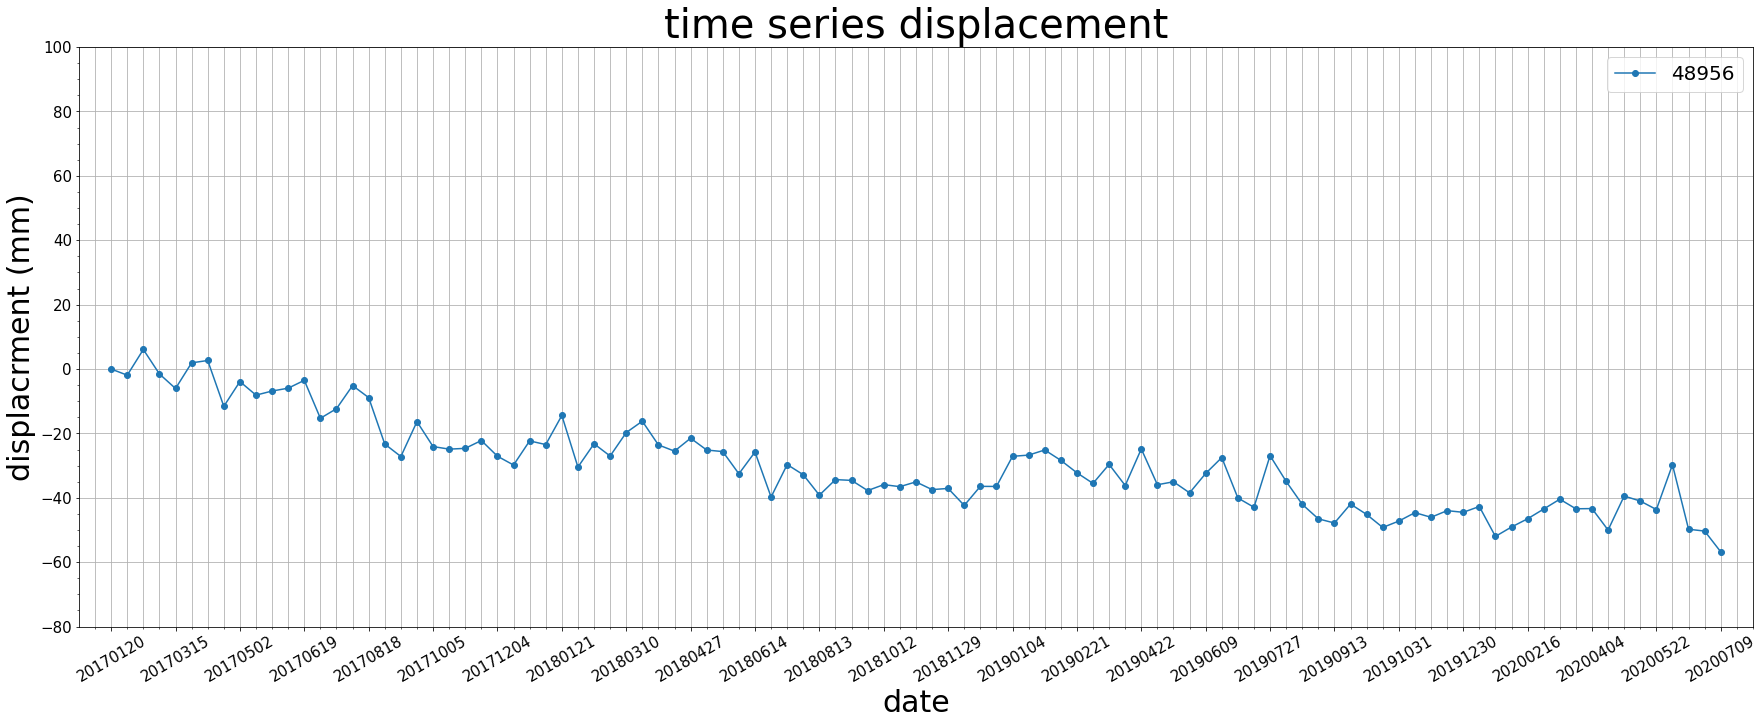

In [100]:
num_list = [48956]
plot_displacement(num_list, ts_data, date, aspect=0.2,
                  figsize=(30, 15), y_lim=[-80, 100])